In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump,load
import cloudpickle

In [17]:
import warnings
warnings.filterwarnings(action="ignore")

## Load Processed Data

In [9]:
train_data = pd.read_csv("../data/train_processed_data.csv")
train_data.drop(columns=["Unnamed: 0"],axis=1,inplace=True)
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,target
0,-1.481411,-0.262831,-0.335514,-0.123297,0.683058,-1.492419,-0.094636,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0
1,-0.536103,-0.369026,-0.335335,-0.230177,0.505376,-0.522977,-0.006963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0
2,0.148821,-0.380366,-0.301520,-0.282502,0.683058,0.169482,0.055627,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0
3,-0.298361,-0.329487,-0.335514,-0.258848,-0.560711,-0.245993,0.016423,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,-1.390843,-0.361408,-0.325133,-0.201263,-0.738393,-1.353927,-0.024703,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75595,-0.173829,-0.381017,-0.243724,-0.282502,-0.916074,-0.107501,0.089331,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
75596,-0.247416,0.512344,-0.335514,0.215003,1.038420,-0.245993,-0.371810,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0
75597,1.190358,0.288776,0.016508,-0.282502,-0.738393,1.277416,0.241084,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1
75598,0.007307,-0.346507,-0.317303,-0.282502,0.505376,0.030990,0.046423,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1


In [10]:
X,y = train_data.drop("target",axis=1),train_data['target']

In [11]:
# Separate Data to Training/Validation
from sklearn.model_selection import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.1,random_state=42,stratify=y)

Some algorithms like SVM dont handle large data well, so we will use small subset of the data to finetune them.

In [12]:
X_subset = X_train.sample(10_000,random_state=42)
y_subset = y_train.loc[X_subset.index]

## Fine Tuning Base Models

In [7]:
from joblib import dump,load
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### KNN

In [8]:
# Load the KNN
knn = load("../models/knn.joblib")
knn

KNeighborsClassifier()

In [23]:
param_grid = {
    "n_neighbors":[10,15,20,30],
    "metric":["euclidean","manhattan"],
    "weights":["uniform","distance"]
}

grid_search = GridSearchCV(knn,param_grid=param_grid,cv=3,scoring="f1")
grid_search.fit(X_subset,y_subset)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [10, 15, 20, 30],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [24]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

- First Time: **{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}**<br>
We see that the best neighbors is 10 which is the max,so we will run other time with large neighbors choices.
- Second Time: **{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}**<br>
We see it stays at **10** which is best while its already overfitting.

In [33]:
# Performace on Training Set
grid_search.score(X_train,y_train)

0.9226343208148666

In [27]:
# Validate Performace on Validation Set
grid_search.score(X_valid,y_valid)

0.9073556797020483

In [28]:
best_knn = grid_search.best_estimator_

In [29]:
# Check CV Results
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,0.017685,0.000499,0.199581,0.000528,manhattan,10,distance,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.888889,0.885281,0.897561,0.890577,0.005153,1
11,0.017680,0.000392,0.231951,0.000783,manhattan,15,distance,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.878771,0.887432,0.894079,0.886761,0.006267,2
13,0.018686,0.000397,0.269633,0.005259,manhattan,20,distance,"{'metric': 'manhattan', 'n_neighbors': 20, 'we...",0.874107,0.888158,0.886339,0.882868,0.006239,3
15,0.017628,0.000472,0.325916,0.009690,manhattan,30,distance,"{'metric': 'manhattan', 'n_neighbors': 30, 'we...",0.859688,0.882125,0.883288,0.875034,0.010861,4
1,0.018847,0.000876,0.220472,0.003588,euclidean,10,distance,"{'metric': 'euclidean', 'n_neighbors': 10, 'we...",0.862466,0.873713,0.883089,0.873089,0.008431,5
3,0.019663,0.002315,0.268933,0.007040,euclidean,15,distance,"{'metric': 'euclidean', 'n_neighbors': 15, 'we...",0.856669,0.867325,0.875000,0.866331,0.007517,6
5,0.018418,0.000910,0.302536,0.010730,euclidean,20,distance,"{'metric': 'euclidean', 'n_neighbors': 20, 'we...",0.853821,0.865672,0.872727,0.864073,0.007801,7
7,0.021042,0.004864,0.377251,0.049879,euclidean,30,distance,"{'metric': 'euclidean', 'n_neighbors': 30, 'we...",0.845465,0.860660,0.863938,0.856688,0.008048,8
10,0.018944,0.000828,0.427716,0.015190,manhattan,15,uniform,"{'metric': 'manhattan', 'n_neighbors': 15, 'we...",0.836735,0.853617,0.859218,0.849857,0.009556,9
8,0.017340,0.000536,0.383363,0.003117,manhattan,10,uniform,"{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.838453,0.851620,0.856332,0.848802,0.007566,10


In [52]:
# Fine Tune Best KNN on all the dataset
best_knn.fit(X_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')

In [54]:
# Store Fine-Tuned KNN
dump(best_knn,"../models/finetuned/best_knn.joblib")

['../models/finetuned/best_knn.joblib']

### SVC

SVC is veryy sloww for large dataset so it will get fine tuned.

In [30]:
# Load the SVC
svc = load("../models/svc.joblib") # Cause Last one used were LinearSVC not SVC

In [32]:
svc.score(X_train,y_train)

0.9207231040564374

In [31]:
svc.score(X_valid,y_valid)

0.9235449735449736

### Decission Tree

In [36]:
# Load the Decision Tree
tree_clf = load("../models/decision_tree.joblib")

In [37]:
param_grid = {
    "criterion":["gini","entropy"],
    "max_depth":[2,5,10,15]
}
grid_search = GridSearchCV(tree_clf,param_grid=param_grid,cv=3,scoring="f1")
grid_search.fit(X_subset,y_subset)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 15]},
             scoring='f1')

In [38]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 15}

In [39]:
# Performace on Training Set
grid_search.score(X_train,y_train)

0.9671469446147557

In [41]:
# Performace on Validatino Set
grid_search.score(X_valid,y_valid)

0.9674461256304449

In [44]:
best_tree = grid_search.best_estimator_

In [42]:
# Check CV Results
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.060908,0.000748,0.004993,0.000017,entropy,15,"{'criterion': 'entropy', 'max_depth': 15}",0.958617,0.960744,0.955844,0.958402,0.002006,1
3,0.061673,0.002206,0.005036,0.000073,gini,15,"{'criterion': 'gini', 'max_depth': 15}",0.952830,0.960248,0.949633,0.954237,0.004446,2
6,0.057305,0.001063,0.004704,0.000514,entropy,10,"{'criterion': 'entropy', 'max_depth': 10}",0.948731,0.954569,0.951307,0.951536,0.002389,3
2,0.060190,0.001410,0.004700,0.000394,gini,10,"{'criterion': 'gini', 'max_depth': 10}",0.945720,0.958269,0.943476,0.949155,0.006509,4
5,0.044248,0.000444,0.004651,0.000467,entropy,5,"{'criterion': 'entropy', 'max_depth': 5}",0.919285,0.911063,0.905425,0.911924,0.005691,5
1,0.042844,0.001125,0.004985,0.000002,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.894247,0.920000,0.897959,0.904069,0.011367,6
0,0.024522,0.003497,0.004982,0.000002,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.733624,0.759659,0.782090,0.758458,0.019804,7
4,0.024731,0.000856,0.004654,0.000449,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.750800,0.738488,0.764096,0.751128,0.010457,8


In [55]:
# Fine Tune Best Decision Tree on all the dataset
best_tree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [56]:
# Store Fine-Tuned Decesion Tree
dump(best_tree,"../models/finetuned/best_tree.joblib")

['../models/finetuned/best_tree.joblib']

### XGB

In [46]:
# Load the XGB
xgb_clf = load("../models/xgb.joblib")

In [47]:
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.7, 0.8, 1.0],
    "n_estimators": [50, 100, 200],
    "gamma": [0, 0.1, 0.2],
}

rnd_search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=10, scoring="accuracy", cv=3, random_state=42, n_jobs=-1)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [48]:
rnd_search.best_params_

{'subsample': 1.0,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.1}

In [49]:
# Performace on Training Set
rnd_search.score(X_train,y_train)

0.9985008818342151

In [50]:
# Performace on Validation Set
rnd_search.score(X_valid,y_valid)

0.9939153439153439

In [60]:
best_xgb = rnd_search.best_estimator_

In [51]:
# Check CV Results
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1.226072,0.030328,0.124971,7.867412e-07,1.0,100,7,0.2,0.1,"{'subsample': 1.0, 'n_estimators': 100, 'max_d...",0.995591,0.994136,0.994180,0.994636,0.000676,1
0,1.387623,0.017564,0.083110,1.694142e-03,0.8,50,10,0.2,0.2,"{'subsample': 0.8, 'n_estimators': 50, 'max_de...",0.994621,0.993078,0.993298,0.993665,0.000681,2
4,1.472104,0.019749,0.141451,8.546633e-04,1.0,100,10,0.1,0.2,"{'subsample': 1.0, 'n_estimators': 100, 'max_d...",0.994356,0.992152,0.992813,0.993107,0.000924,3
6,1.048928,0.014727,0.079848,2.460702e-03,0.7,50,7,0.2,0.2,"{'subsample': 0.7, 'n_estimators': 50, 'max_de...",0.993607,0.991667,0.992416,0.992563,0.000799,4
8,3.282782,0.024379,0.156704,7.039123e-03,0.7,200,5,0.05,0.1,"{'subsample': 0.7, 'n_estimators': 200, 'max_d...",0.991138,0.989286,0.990168,0.990197,0.000756,5
3,2.293866,0.014315,0.148605,2.154204e-03,0.7,100,10,0.01,0,"{'subsample': 0.7, 'n_estimators': 100, 'max_d...",0.985758,0.982099,0.984568,0.984142,0.001524,6
1,1.439485,0.006164,0.057181,4.704158e-04,0.7,100,3,0.1,0,"{'subsample': 0.7, 'n_estimators': 100, 'max_d...",0.982055,0.977646,0.983201,0.980967,0.002395,7
2,0.827788,0.002445,0.038230,4.694040e-04,0.7,50,3,0.05,0.1,"{'subsample': 0.7, 'n_estimators': 50, 'max_de...",0.963713,0.960229,0.964859,0.962934,0.001969,8
9,1.474412,0.107110,0.050821,8.172194e-03,0.8,100,3,0.01,0.1,"{'subsample': 0.8, 'n_estimators': 100, 'max_d...",0.945591,0.942549,0.942945,0.943695,0.001350,9
7,1.035332,0.008970,0.058033,4.870171e-03,0.8,50,5,0.01,0.1,"{'subsample': 0.8, 'n_estimators': 50, 'max_de...",0.941138,0.925750,0.930291,0.932393,0.006456,10


In [61]:
# Fine Tune Best XGBoost on all the dataset
best_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
# Store Fine-Tuned XGB Tree
dump(best_xgb,"../models/finetuned/best_xgb.joblib")

['../models/finetuned/best_xgb.joblib']

## Ensemble Learning

### Voting

In [64]:
from sklearn.ensemble import VotingClassifier

In [78]:
voting_clf = VotingClassifier(estimators=[
    ("knn",best_knn),
    ("svc",svc),
    ("tree",best_tree),
    ("xgb",best_xgb)
],voting="hard")
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=10,
                                                   weights='distance')),
                             ('svc', LinearSVC()),
                             ('tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=15)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_st...
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))])

In [79]:
voting_clf.score(X_train,y_train)

0.99891240446796

In [80]:
voting_clf.score(X_valid,y_valid)

0.9935185185185185

In [96]:
# Save it
dump(voting_clf,"../models/finetuned/voting_classifier.joblib")

['../models/finetuned/voting_classifier.joblib']

### Stacking

In [81]:
from sklearn.ensemble import StackingClassifier

In [82]:
staking_clf = StackingClassifier(estimators=[
    ("knn",best_knn),
    ("svc",svc),
    ("tree",best_tree),
    ("xgb",best_xgb)
],final_estimator=best_xgb)
staking_clf.fit(X_train,y_train)

StackingClassifier(estimators=[('knn',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=10,
                                                     weights='distance')),
                               ('svc', LinearSVC()),
                               ('tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=15)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_...
                                                 feature_types=None, gamma=0.1,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.2,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=7, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...))

In [83]:
staking_clf.score(X_train,y_train)

0.9995002939447384

In [84]:
staking_clf.score(X_valid,y_valid)

0.995899470899471

In [93]:
# Save it
dump(staking_clf,"../models/finetuned/stacking_classifier.joblib")

['../models/finetuned/stacking_classifier.joblib']

## Performances

In [14]:
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay,precision_score,recall_score,f1_score,roc_auc_score

def validate_model(model,X,y,scoring="accuracy",cv=3):
    score = cross_val_score(estimator=model,X=X,y=y,scoring=scoring,cv=cv)
    print(f"{scoring.title()} Mean= {np.mean(score):.2%}")
    print(f"{scoring.title()} Std= {np.std(score):.2}")

    preds = cross_val_predict(estimator=model,X=X,y=y,cv=cv)
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_true=y,y_pred=preds)
    
    model_name = model.__class__.__name__
    plt.savefig(f"../visualizations/FineTune/{model_name}.png", dpi=300, bbox_inches='tight')

    f1 = f1_score(y,preds)
    roc_auc = roc_auc_score(y,preds)
    # Precision, Recall ,ROC AUC and F1 Scores
    print(f"Precision= {precision_score(y,preds):.2%}")
    print(f"Recall= {recall_score(y,preds):.2%}")
    print(f"F1= {f1:.2%}")
    print(f"ROC AUC= {roc_auc:.2%}")
    return f1,roc_auc

#### Voting Classifier

Accuracy Mean= 99.06%
Accuracy Std= 0.00087
Precision= 99.11%
Recall= 97.60%
F1= 98.35%
ROC AUC= 98.63%


(0.9835164835164836, 0.9862654320987653)

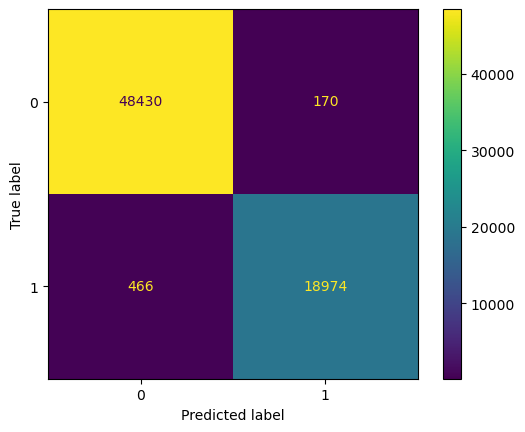

In [20]:
validate_model(voting_clf,X_train,y_train)

#### Stacking Classifier

Accuracy Mean= 99.52%
Accuracy Std= 0.00044
Precision= 99.03%
Recall= 99.28%
F1= 99.15%
ROC AUC= 99.45%


(0.9915491510621356, 0.9944701646090535)

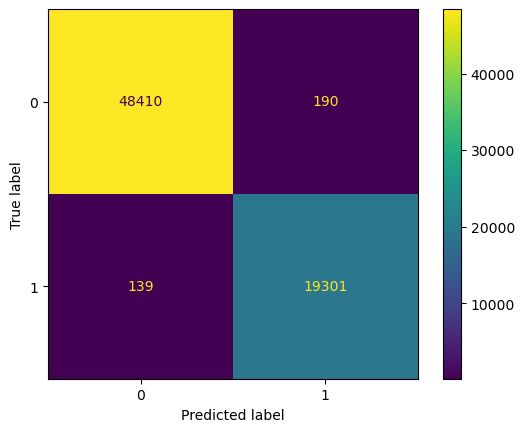

In [21]:
validate_model(staking_clf,X_train,y_train)

We see **Stacking Classifier** is miles better than **Voting** at Type1 Error.

## Performance on the test set

In [109]:
# Load Test Data
test_data = pd.read_csv("../data/test_data.csv")

In [103]:
# Load Data Pipeline to process Raw Test Data
with open("../pipelines/pipeline.pkl", "rb") as f:
    pipeline = cloudpickle.load(f)

In [110]:
X_test,y_test = test_data.drop("isFraud",axis=1),test_data['isFraud']

In [112]:
X_test_processed = pipeline.transform(X_test)

In [116]:
y_pred = staking_clf.predict(X_test_processed)
y_pred

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [120]:
from sklearn.metrics import accuracy_score
print(f"Accuracy= {accuracy_score(y_test,y_pred):.2%}")
print(f"Precision= {precision_score(y_test,y_pred):.2%}")
print(f"Recall= {recall_score(y_test,y_pred):.2%}")
print(f"F1= {f1_score(y_test,y_pred):.2%}")
print(f"ROC AUC= {roc_auc_score(y_test,y_pred):.2%}")

Accuracy= 99.62%
Precision= 99.37%
Recall= 99.29%
F1= 99.33%
ROC AUC= 99.52%


Wow, amazing.